In [1]:
import datetime
import os
import re
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from db_utils.db_queries import sql_all_reports_with_weather
# from db_utils.mysql_db_connection import get_mysql_connection

from webscraping.scrape_fishing_data import clean_string

warnings.filterwarnings("ignore")

## Read and format the data

In [2]:
fishing_data = pd.read_csv("./raw_fishing_data.csv")

In [3]:
fishing_data

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.00,10.0,10.0,30.08
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.00,10.0,9.0,30.23
2,2020-12-16,GOOD ACTION,Another good day of fishing for the guys. It w...,43.0,56.38,72.0,0.00,10.0,9.0,30.17
3,2020-12-15,GOOD DAY,The guys had an awesome day pulling on Yellowf...,49.0,57.24,68.0,0.03,10.0,9.0,30.21
4,2020-12-14,GOOD SIGN,Beautiful weather for the guys today. Their ar...,51.0,56.68,64.0,0.00,10.0,10.0,30.12
...,...,...,...,...,...,...,...,...,...,...
2903,2006-01-03,Had Some Weather,Independence arrived at Pt Loma Sportfishing J...,50.0,55.57,61.0,0.00,10.0,20.0,30.23
2904,2020-12-19,ETA,The Independence will dock at Point Loma Sport...,43.0,56.67,70.0,0.00,10.0,14.0,30.28
2905,2020-08-25,GREAT TRIP,What a trip the guys had Started our trip out ...,73.0,75.59,80.0,0.00,10.0,14.0,29.84
2906,2017-12-20,AFTCO REPS COMMENTS,The trip started off at the bait receivers whe...,48.0,56.24,63.0,0.00,10.0,12.0,30.17


In [4]:
DATE_PATTERN = re.compile(r"\d+/\d+/\d+")

# match times like 3:30pm or 3:40 am
TIME_PATTERN = re.compile(r"\d+:\d+\s*(pm|am)", re.IGNORECASE)

In [5]:
def replace_dates(post):
    return DATE_PATTERN.sub("DATE__STAMP", post)

def replace_times(post):
    return TIME_PATTERN.sub("TIME__STAMP", post)

In [6]:
replace_dates("does 3/10/2020 sound right? how about 2020/10/3?")

'does DATE__STAMP sound right? how about DATE__STAMP?'

In [7]:
replace_times("lets meet around 12:40PM. Wait, does 1:45 Am work?")

'lets meet around TIME__STAMP. Wait, does TIME__STAMP work?'

In [8]:
# convert the date to a date object for consistency in our analysis + make pandas happy
fishing_data.loc[:, 'date_posted'] = pd.to_datetime(fishing_data.loc[:, 'date_posted'], format="%Y-%m-%d", cache=True)

# convert times and dates to a common value to reduce vocabulary size.
fishing_data.loc[:, 'post_body'] = fishing_data.loc[:, 'post_body'].astype(str).apply(replace_dates)
fishing_data.loc[:, 'post_body'] = fishing_data.loc[:, 'post_body'].astype(str).apply(replace_times)

# clean punctuation from the post bodies. makes our lives harder and doesnt contribute much
fishing_data.loc[:, 'post_body'] = fishing_data.loc[:, 'post_body'].astype(str).apply(clean_string)


In [9]:
el_nino_years = [2002, 2003, 2004, 2005, 2006, 2007, 2009, 2010, 2014, 2015, 2016, 2018, 2019]

In [10]:
fishing_data.loc[:, 'elnino'] = fishing_data.date_posted.dt.year.isin(el_nino_years)

## Check for duplicate rows 

In [11]:
fishing_data.loc[fishing_data.duplicated(subset=['headline', 'post_body', 'date_posted'], keep=False)].sort_values("date_posted")

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure,elnino
2548,2007-08-30,Indy Sportfishing Fish Report 08-30-07,Here is the report for today We fished for alb...,71.0,74.35,80.0,0.0,10.0,9.0,29.87,True
2547,2007-08-30,Indy Sportfishing Fish Report 08-30-07,Here is the report for today We fished for alb...,71.0,74.35,80.0,0.0,10.0,9.0,29.87,True
2478,2007-12-02,Indy Sportfishing Fish Report 12-02-07,Good evening we had another great day at the b...,48.0,54.43,60.0,0.0,10.0,12.0,30.41,True
2477,2007-12-02,Indy Sportfishing Fish Report 12-02-07,Good evening we had another great day at the b...,48.0,54.43,60.0,0.0,10.0,12.0,30.41,True
2354,2008-08-26,Independence Sportfishing Fish Report,Good day heres an update from our trip so far ...,69.0,71.16,75.0,0.0,10.0,9.0,29.81,False
2353,2008-08-26,Independence Sportfishing Fish Report,Good day heres an update from our trip so far ...,69.0,71.16,75.0,0.0,10.0,9.0,29.81,False
2336,2008-10-03,"Independence Fish Report for Oct. 3, 2008",Well today we continued our hunt down into the...,66.0,68.45,70.0,0.0,10.0,12.0,29.90,False
2335,2008-10-03,"Independence Fish Report for Oct. 3, 2008",Well today we continued our hunt down into the...,66.0,68.45,70.0,0.0,10.0,12.0,29.90,False
2332,2008-10-06,"Independence Fish Report for Oct. 06, 2008",Hello Here is the final report for our trip To...,62.0,69.52,79.0,0.0,10.0,13.0,29.96,False
2331,2008-10-06,"Independence Fish Report for Oct. 06, 2008",Hello Here is the final report for our trip To...,62.0,69.52,79.0,0.0,10.0,13.0,29.96,False


There are 13 duplicate posts that leaked into the data. We'll get rid of these so they don't skew any of our analysis.

In [12]:
fishing_data = fishing_data.drop_duplicates().reset_index(drop=True)
fishing_data.head(2)

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure,elnino
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.0,10.0,10.0,30.08,False
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.0,10.0,9.0,30.23,False


## Duplicate dates

In [13]:
# are there multiple posts for any days?
post_counts = fishing_data.date_posted.value_counts()
post_counts[post_counts >= 2]

2017-04-30    9
2017-09-26    9
2017-04-28    7
2017-12-05    7
2018-04-21    7
             ..
2008-10-27    2
2011-06-16    2
2009-12-08    2
2011-08-12    2
2014-08-28    2
Name: date_posted, Length: 411, dtype: int64

Is it concerning that dates are duplicated? Let's check one of the dates that has 9 posts.

In [14]:
sample_date = pd.Timestamp(datetime.date(2017, 9, 26))
duplicate_date_example = fishing_data.loc[fishing_data.date_posted == sample_date]
duplicate_date_example

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure,elnino
498,2017-09-26,Excellent Start Kimura 8 Day,We departed Sunday on our annual Gary Kimura 8...,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False
499,2017-09-26,beautiful dorados today,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False
500,2017-09-26,beautiful yellowtail,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False
501,2017-09-26,happy camper,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False
502,2017-09-26,YELLOWTAIL BONANZA,nan,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False
503,2017-09-26,Matt,Matt brings in a beautiful Yellowtail,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False
504,2017-09-26,Alex,Nice yellow today,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False
505,2017-09-26,Robert,Robert says Hello to all my friends,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False
506,2017-09-26,trip 1722 Jackpot winners,First place Tim Brown 57 8 Second place Vince ...,63.0,69.92,78.0,0.0,10.0,10.0,29.82,False


There seem to be days where the crew posts many times, sometimes without a post body. It's likely that these are accompanied by pictures on the actual site since the headlines are things like, `Matt brings in a beautiful Yellowtail`, though we didn't webscrape photos. More posts in a day may be an indicator of good fishing conditions. 

## When do posts happen?

#### Let's see how posts are distributed by year

In [15]:
# What is the earliest post and the most recent post by date?
sorted_dates = fishing_data.date_posted.sort_values()
sorted_dates.iloc[0], sorted_dates.iloc[-1]

(Timestamp('2005-06-19 00:00:00'), Timestamp('2020-12-19 00:00:00'))

In [16]:
# uncomment this to see just the numbers per year 
# (useful for spotchecking the bar plot since more plot options = room for error)

# fishing_data.date_posted.dt.year.value_counts()

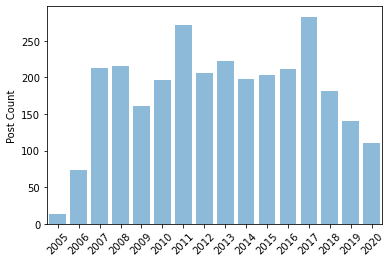

In [17]:
time_hist_options = {
    "alpha":  0.5,
    "rwidth": 0.8,
    "bins":   np.arange(2005, 2020 + 2),
    "align":  "left"
}
plt.hist(fishing_data.date_posted.dt.year, **time_hist_options)
plt.ylabel("Post Count")
plt.xticks(time_hist_options['bins'], rotation=45)
plt.xlim([2004.5, 2020.5]);

Posts were fairly consistent in the late 2000s and 2010s, though this is clear dropoff in recent years. Drops in 2020 were almost certainly correlated with covid though there was an existing downward trend.

Note: The average post per day is less than 1 for every year in the dataset. Because the crew didn't post every day, it's likely that good days are overrepresented.

#### What about the distribution by month? Is there seasonality to the posts?

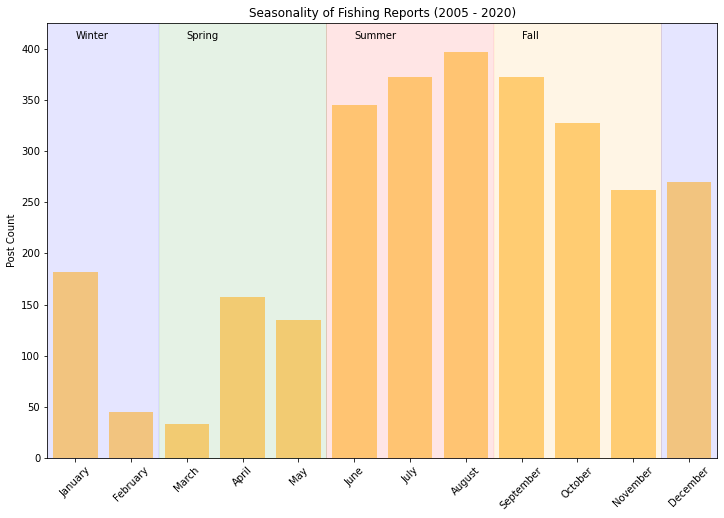

In [18]:
plt.figure(figsize=(12, 8))
month_labels = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]

month_hist_options = {
    "alpha":  0.5,
    "color":  "orange"
}

month_counts = fishing_data.date_posted.dt.month.value_counts().sort_index()

plt.bar(month_counts.index, month_counts.values, **month_hist_options)
plt.ylabel("Post Count")
plt.xticks(month_counts.index, labels=month_labels, rotation=45);


# Custom fill patterns to emphasize seasons
plt.fill_between([2.5, 5.49], 500,  alpha=0.1, color='green',  label='Spring')
plt.fill_between([5.5, 8.49], 500,  alpha=0.1, color='red',    label='Summer')
plt.fill_between([8.5, 11.49], 500, alpha=0.1, color='orange', label='Fall')
plt.fill_between([0, 2.49], 500,    alpha=0.1, color='blue',   label='Winter')
plt.fill_between([11.5, 12.5], 500, alpha=0.1, color='blue')

plt.annotate("Winter", [1, 410])
plt.annotate("Spring", [3, 410])
plt.annotate("Summer", [6, 410])
plt.annotate("Fall",   [9, 410])

plt.title("Seasonality of Fishing Reports (2005 - 2020)");
plt.ylim([0, 425])
plt.xlim([0.5, 12.5]);

#plt.savefig("post_seasonality.png", dpi=500);

Though posts aren't necessarily equivalent to business activity, this plot suggests that the fishing business may be more active in hotter months. This makes intuitive sense since we wouldn't expect people to be out in the rain or cold to catch fish, especially when the waters may be choppy or otherwise le.

### Rain patterns over the years

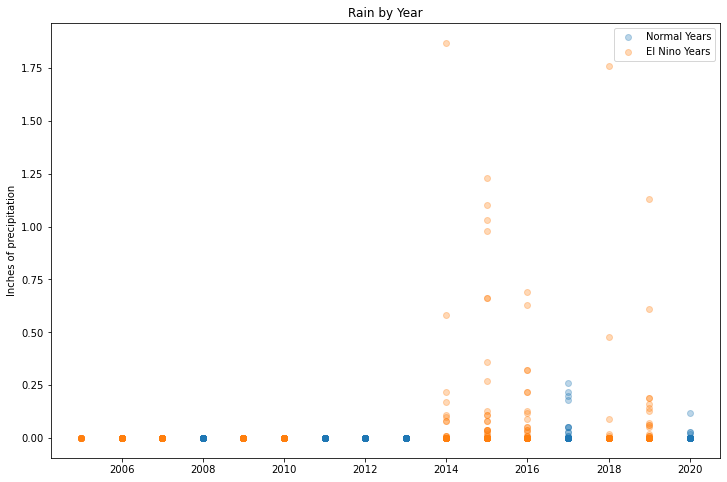

In [22]:
plt.figure(figsize=(12, 8))
norm_years = fishing_data.loc[~fishing_data.elnino]
nino_years = fishing_data.loc[fishing_data.elnino]

plt.scatter(norm_years.date_posted.dt.year, norm_years.inches_precip, alpha=0.3, label='Normal Years')
plt.scatter(nino_years.date_posted.dt.year, nino_years.inches_precip, alpha=0.3, label='El Nino Years')

plt.ylabel("Inches of precipitation");
plt.title("Rain by Year")
plt.legend();

Before 2014 there is no rain data. Either the site we scraped weather data from didn't have correct measurements of the rain or we got unlucky and none of the posts occurred on days where there was rain. Given that there aren't many posts during rainy months, the latter is possible. We shouldn't use rain for anything serious in our analysis.

### El Nino Years

I got these years from Wikipedia. There is no obvious difference in weather in El Niño years, so I likely won't use this variable for anything.

In [20]:
fishing_data.groupby('elnino')[['low_temp', 'avg_temp', 'high_temp', 'sea_pressure']].agg(['mean', 'median'])

low_temp          avg_temp         high_temp        sea_pressure  \
             mean median       mean median       mean median         mean   
elnino                                                                      
False   58.045872   62.0  65.561942  65.81  71.746942   72.0    29.982913   
True    61.513531   63.0  66.545267  66.58  72.664569   72.0    29.989906   

               
       median  
elnino         
False   29.97  
True    29.98

## Daily Temperatures

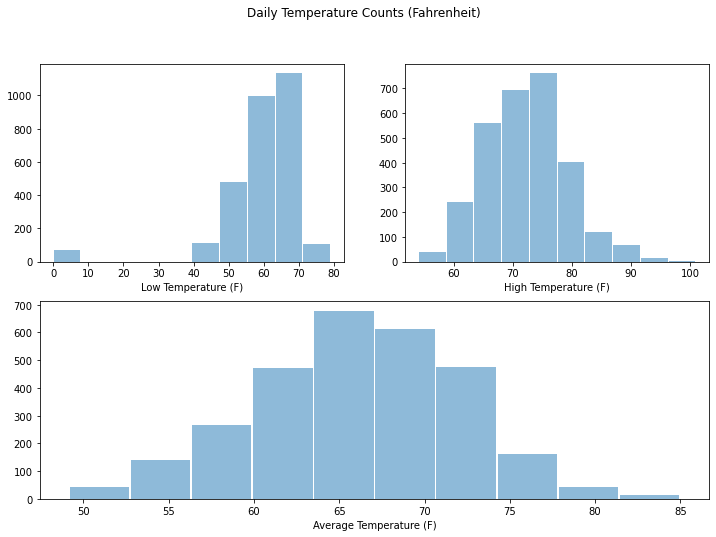

In [21]:
# thanks for the grid help: 
# https://stackoverflow.com/questions/37360568/python-organisation-of-3-subplots-with-matplotlib
import matplotlib.gridspec as gridspec

temp_plot_options = {
    "alpha":  0.5,
    "rwidth": 0.97
}

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12, 8))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.suptitle("Daily Temperature Counts (Fahrenheit)")

plt.hist(fishing_data.low_temp, **temp_plot_options)
plt.xlabel("Low Temperature (F)")

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.hist(fishing_data.high_temp, **temp_plot_options)
plt.xlabel("High Temperature (F)")

ax = plt.subplot(gs[1, :]) # row 1, span all columns
plt.hist(fishing_data.avg_temp, **temp_plot_options)
plt.xlabel("Average Temperature (F)");

In [23]:
norm_years, nino_years

(     date_posted             headline  \
 0     2020-12-17          ON THE HUNT   
 1     2020-12-18      SCRATCHING AWAY   
 2     2020-12-16          GOOD ACTION   
 3     2020-12-15             GOOD DAY   
 4     2020-12-14            GOOD SIGN   
 ...          ...                  ...   
 2827  2008-01-05      Toured the Boat   
 2893  2020-12-19                  ETA   
 2894  2020-08-25           GREAT TRIP   
 2895  2017-12-20  AFTCO REPS COMMENTS   
 2896  2017-04-26          Indy Update   
 
                                               post_body  low_temp  avg_temp  \
 0     We were on the hunt for Yellowtail today but n...      46.0     57.34   
 1     Searched for Yellowtail again today to find no...      52.0     58.04   
 2     Another good day of fishing for the guys It wa...      43.0     56.38   
 3     The guys had an awesome day pulling on Yellowf...      49.0     57.24   
 4     Beautiful weather for the guys today Their are...      51.0     56.68   
 ...          

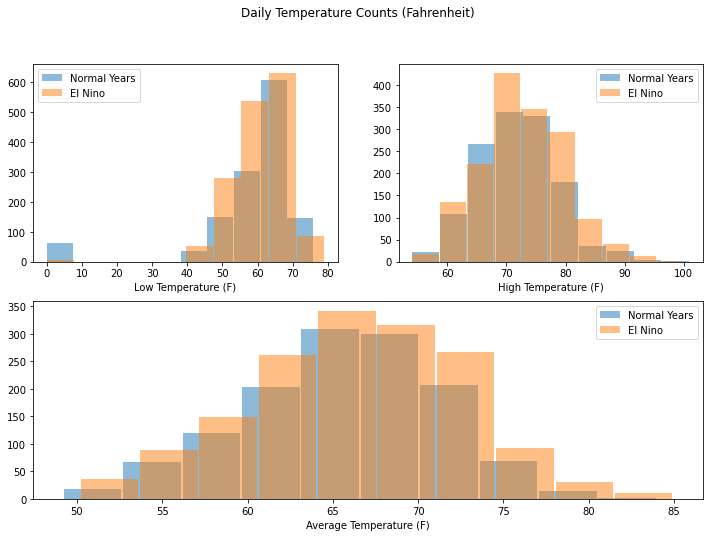

In [24]:
# thanks for the grid help: 
# https://stackoverflow.com/questions/37360568/python-organisation-of-3-subplots-with-matplotlib
import matplotlib.gridspec as gridspec

temp_plot_options = {
    "alpha":  0.5,
    "rwidth": 0.97
}

# Create 2x2 sub plots
gs = gridspec.GridSpec(2, 2)

plt.figure(figsize=(12, 8))
ax = plt.subplot(gs[0, 0]) # row 0, col 0
plt.suptitle("Daily Temperature Counts (Fahrenheit)")

plt.hist(norm_years.low_temp, **temp_plot_options, label='Normal Years')
plt.hist(nino_years.low_temp, **temp_plot_options, label='El Nino')
plt.xlabel("Low Temperature (F)")
plt.legend();

ax = plt.subplot(gs[0, 1]) # row 0, col 1
plt.hist(norm_years.high_temp, **temp_plot_options, label='Normal Years')
plt.hist(nino_years.high_temp, **temp_plot_options, label='El Nino')
plt.xlabel("High Temperature (F)")
plt.legend();

ax = plt.subplot(gs[1, :]) # row 1, span all columns
plt.hist(norm_years.avg_temp, **temp_plot_options, label='Normal Years')
plt.hist(nino_years.avg_temp, **temp_plot_options, label='El Nino')
plt.xlabel("Average Temperature (F)")
plt.legend();

The daily low temperatures have outlier values near 0. San Diego doesn't randomly hit sub-freezing temperatures, skipping everything from 32 down to 0, so we can be sure these are errors in the weather site's data.

As for the rest of the temperatures, the average and high look well-behaved. It may be worth looking for relationships between temperature and post content.

## Annual weather data

In [25]:
fishing_data.groupby(fishing_data.date_posted.dt.year)[['low_temp', 'avg_temp', 'high_temp', 'sea_pressure']].agg(['mean', 'median'])

low_temp          avg_temp          high_temp         \
                  mean median       mean  median       mean median   
date_posted                                                          
2005         58.153846   57.0  61.473077  60.480  66.076923   65.0   
2006         57.438356   54.0  62.851370  60.070  69.534247   68.0   
2007         61.014085   62.0  65.169953  65.780  70.342723   71.0   
2008         59.972093   60.0  65.314279  66.740  71.497674   73.0   
2009         58.583851   61.0  64.285714  64.620  70.372671   71.0   
2010         58.454082   60.5  63.353878  64.330  69.321429   69.0   
2011         56.357934   61.0  63.977638  64.810  69.752768   70.0   
2012         56.509709   62.0  65.601990  65.105  71.339806   71.0   
2013         52.493274   60.0  64.687085  65.240  70.708520   71.0   
2014         64.580808   66.0  69.753636  70.565  75.878788   76.0   
2015         63.541872   66.0  68.935468  70.040  75.206897   76.0   
2016         61.672986   63.0  66.755355  67.630  73.355450   73.0   
2017         62.335689   63.0  67.250459  67.290  73.883392   74.0   
2018         63.701657   65.0  68.871436  68.670  75.497238   75.0   
2019         62.014286   63.0  66.773857  66.710  72.821429   73.0   
2020         61.536364   64.0  67.303636  68.480  74.518182   74.5   

            sea_pressure         
                    mean median  
date_posted                      
2005           30.043846  30.08  
2006           30.050959  30.04  
2007           29.973568  29.96  
2008           29.977721  29.96  
2009           29.989752  29.97  
2010           30.001071  29.99  
2011           29.987823  29.96  
2012           29.985097  29.97  
2013           29.984484  29.97  
2014           29.966919  29.97  
2015           29.975714  29.95  
2016           30.008673  30.00  
2017           29.972721  29.95  
2018           29.992873  29.98  
2019           29.983429  29.97  
2020           29.999909  29.99

## What are the posts about?

For a first pass, we can simply look at the top words used (ignoring filler words)

In [26]:
# We'll ignore these words. They're too common to be useful
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
           'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
           'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
           'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
           'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
           'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
           'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
           'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
           'by', 'for', 'with', 'about', 'against', 'between', 'into',
           'through', 'during', 'before', 'after', 'above', 'below', 'to',
           'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
           'again', 'further', 'then', 'once', 'here', 'there', 'when',
           'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
           'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own',
           'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will',
           'just', 'don', 'should', 'now']

stopwords = set(stopwords)

In [27]:
all_posts = " ".join(fishing_data.post_body.values)

tokens = all_posts.lower().split()
tokens = [t for t in tokens if t not in stopwords]

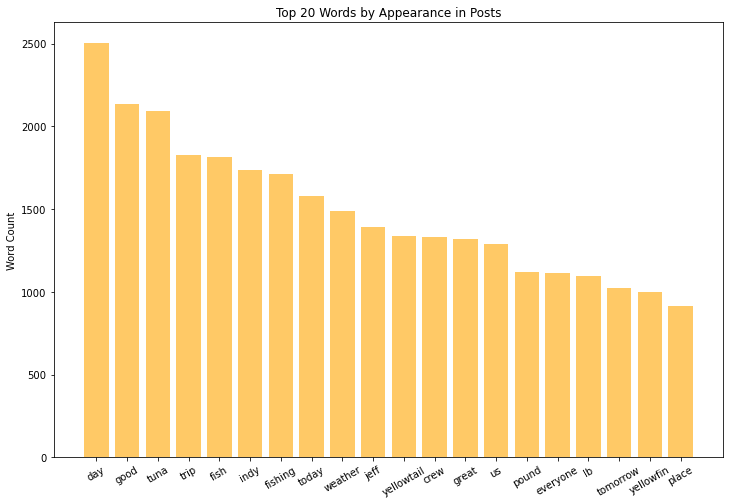

In [28]:
n = 20
top_n_words = pd.Series(tokens).value_counts().iloc[:n]

plt.figure(figsize=(12, 8))

plt.bar(top_n_words.index, top_n_words.values, alpha=0.6, color='orange')
plt.xticks(rotation=30)

plt.title(f"Top {n} Words by Appearance in Posts")
plt.ylabel("Word Count");

## Top Words in Fishing Reports

With the stopwords removed, we get mostly unique words with distinct meanings. It's a good sign that `tuna`, `yellowtail`, and `yellowfin` appear in the top words since we are more likely to be able to extract something interesting from the text. Additionally, `pound` and `lb` appearing are indicators that some posts are likely discussing the size of their catches. 

Given the top words look interesting, it may be worth looking for common phrases as well. We'll use a package called `gensim` to find these, but let's take a look at some of the math that's used under the hood to extract phrases. One way to think about phrase extraction is to think about common phrases as a collection of words that appear with each other by more than random chance. For example, the phrase "fishing is cool" is much less distinct than the phrase, "yellowfin tuna". 

"Yellowfin tuna" is a distinct phrase since the two words appear together frequently and they form a set of words that has a specific meaning together than individually. We'd like a sytematic way to find such phrases. But how? A mathematical way to approach this problem is to look at the *Pointwise Mutual Information* of word pairs.

### Beyond Single Words: Phrase Finding with Pointwise Mutual Information (PMI)

Roughly, PMI in the context of phrase finding can be thought of as measuring how associated two words are. It takes into account how often they appear altogether and compares this value to how often they appear together.

We define PMI as,

$$PMI(i, j) = log_2\frac{p(w_i, w_j)}{p(w_i)p(w_j)}$$

Where $i$ and $j$ are the indices of two words of interest, $p(w_i, w_j)$ is the probability of the two words occurring together, and $p(w_i)$ and $p(w_j)$ are the overall probabilities of the words occurring on any document (sometimes called the word frequency).


#### Limiting cases: two words are independent (not phrases)

We can expand the PMI formula using Bayes' rule like,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)p(w_j)}{p(w_i)p(w_j)} = log_2\frac{p(w_i|w_j)}{p(w_i)}$$

This is interesting because if $w_i$ and $w_j$ are independent, then $p(w_i|w_j) = p(w_i)$, so the calculation is simple,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)}{p(w_i)} = log_2\frac{p(w_i)}{p(w_i)} = log_2 1 = 0$$

#### Limiting cases: two words always cooccur (extreme case of phrases)

If the words always occur together, say 99% of the time, then $p(w_i|w_j) \approx 0.99 $. Let's imagine the words themselves are relatively uncommon, so their individual frequency may be something like, $p(w_i) \approx \frac{1}{10,000}$. 

Expanding the PMI calculation,

$$PMI(i, j) = log_2\frac{p(w_i|w_j)}{p(w_i)} = log_2\frac{0.99}{\frac{1}{10,000}} \approx log_2 10,000 \approx 13.3 $$




#### High PMI -> likely to be a phrase, low PMI -> words probably aren't phrases 

In the two extreme cases, we see that independent words have a PMI of 0, while words that occur together all the time have a large PMI (13.3 in our example). This idea underpins a common strategy to find phrases. We will avoid reinventing the wheel, but keep this in mind as we move forward - there is no magic to the calculations we do. 


## Let's see if Gensim can find any interesting phrases

Referencing this thorough article on [topic modeling with Gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#9createbigramandtrigrammodels), we can get phrases from our text fairly simply. We'll start by dropping empty posts and doing light processing on the posts to make them into lists of words.

In [29]:
minimum_chars = 5
non_empty_posts = fishing_data.loc[fishing_data.loc[:, "post_body"].apply(lambda x: len(x.strip())) > minimum_chars]

In [30]:
split_docs = list(fishing_data.post_body.apply(lambda post: post.lower().split()).values)
print("Example documents: \n", split_docs[:2])

Example documents: 
 [['we', 'were', 'on', 'the', 'hunt', 'for', 'yellowtail', 'today', 'but', 'never', 'able', 'to', 'connect', 'we', 'covered', 'a', 'lot', 'of', 'water', 'for', 'a', 'handful', 'of', 'fish', 'were', 'not', 'giving', 'up', 'on', 'yellowtail', 'tomorrow', 'is', 'a', 'new', 'day', 'wish', 'us', 'luck', 'brian', 'indy', 'crew'], ['searched', 'for', 'yellowtail', 'again', 'today', 'to', 'find', 'non', 'biters', 'good', 'action', 'on', 'bass', 'barracuda', 'and', 'bonito', 'for', 'our', 'efforts', 'well', 'be', 'traveling', 'up', 'to', 'be', 'home', 'on', 'sunday', 'nice', 'weather', 'for', 'our', 'travels', 'brian', 'indy', 'crew']]


Here we set up the code to find phrases in our documents. Notice that scoring parameter is [`npmi`](https://en.wikipedia.org/wiki/Pointwise_mutual_information#Normalized_pointwise_mutual_information_(npmi)). It's basically the same as the PMI we talked about before, though normalized to have scores in the range [-1, 1]. A higher threshold means that it takes more for words to get merged into phrases, thus there will be less of them. This can be tuned for your problem, but I'll run with 0.5.

In [31]:
import gensim

In [32]:
phrase_options = {
    "scoring": "npmi",
    "threshold": 0.5,
    "common_terms": stopwords
}

# Build the bigram and trigram models
bigram  = gensim.models.Phrases(split_docs, min_count=5, **phrase_options) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[split_docs], **phrase_options)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [33]:
def apply_phraser_to_doc(doc):
    """
    given a list of strings like,
    
    ['hi', 'how', 'are', 'you']
    
    returns the same list with any phrases merged together via a "_" character (gensim default).
    
    PS: will combine up to ~4 words together, though it can go higher depending on stopword usage
    """
    return trigram_mod[bigram_mod[doc]]

In [34]:
# what phrases are in the first post?
[word for word in apply_phraser_to_doc(split_docs[0]) if "_" in word]

['covered_a_lot_of_water', 'wish_us_luck', 'indy_crew']

## Inspecting the phrases 

Now that we have a way to extract common phrases, let's count all of the phrases that showed up.

In [35]:
split_phrased_docs = [apply_phraser_to_doc(doc) for doc in split_docs]

In [36]:
joined_phrased_docs = [" ".join(doc) for doc in split_phrased_docs]

In [37]:
# combine every post into one, split it into words, then keep the phrases
all_tokens = " ".join(joined_phrased_docs).split()

all_phrases = [word for word in all_tokens if "_" in word]

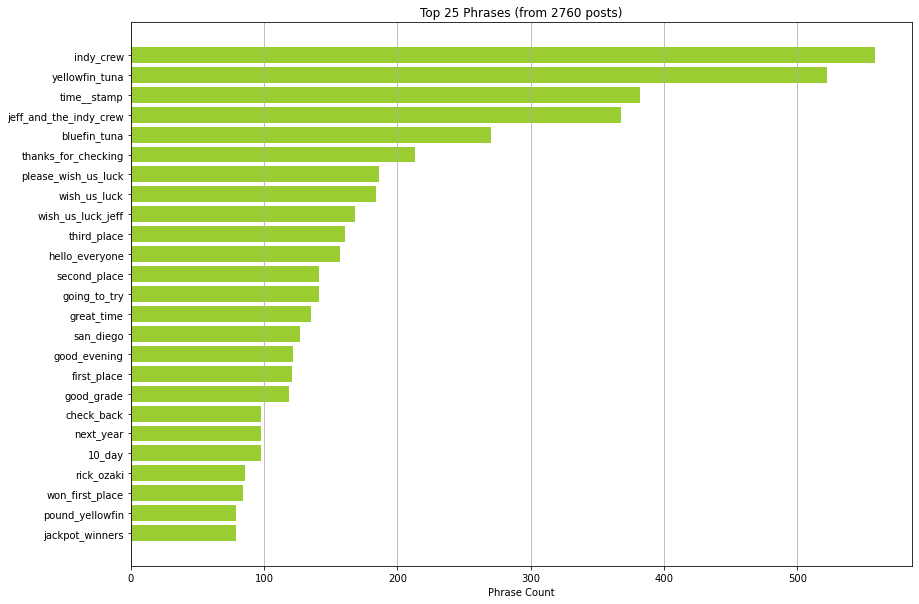

In [38]:
n = 25
top_n_phrases = pd.Series(all_phrases).value_counts().iloc[:n]

plt.figure(figsize=(14, 10))

plt.barh(top_n_phrases.index, top_n_phrases.values, color='yellowgreen')
plt.gca().invert_yaxis() # prefer decreasing order of the bars

plt.title(f"Top {n} Phrases (from {len(non_empty_posts)} posts)")
plt.xlabel("Phrase Count")


plt.grid(axis='x');


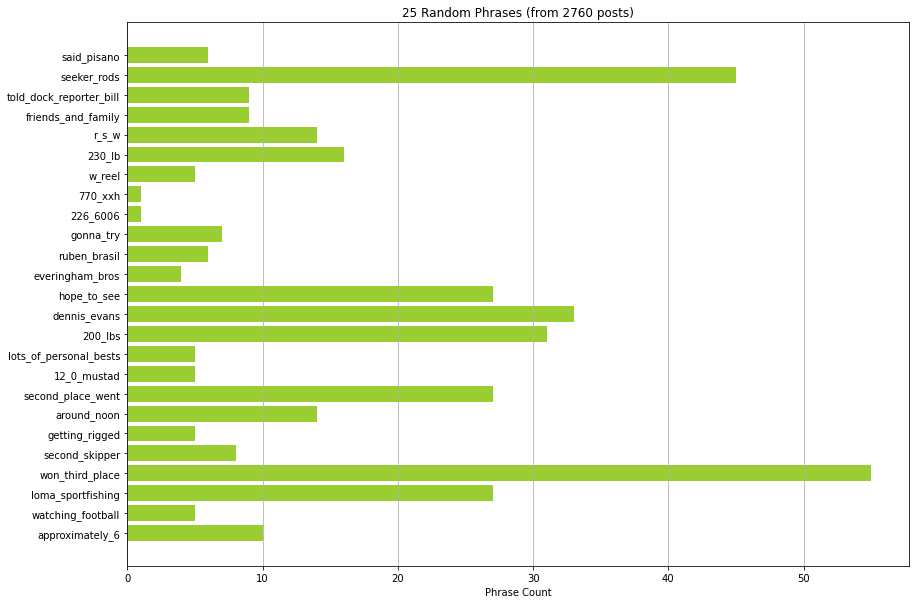

In [39]:
# np.random.seed(504)
top_n_phrases = pd.Series(all_phrases).value_counts().sample(25)

plt.figure(figsize=(14, 10))

plt.barh(top_n_phrases.index, top_n_phrases.values, color='yellowgreen')
plt.gca().invert_yaxis() # prefer decreasing order of the bars

plt.title(f"25 Random Phrases (from {len(non_empty_posts)} posts)")
plt.xlabel("Phrase Count")

plt.grid(axis='x');

## What do these phrases mean?

For some phrases, the meaning is clear. `bluefin_tuna` and `yellowfin_tuna` at the top are clear indications that 
San Diego's reputation as a hotbed for tuna fishing hold true. For others, it may be useful to read a few posts and understand the context of the phrase.

We'll define a helper function to print a few examples of the more mysterious phrases in their original context.

In [40]:
def print_phrase_with_context(phrase, num_docs):
    """
    prints the first `num_docs` documents with the phrase highlighted
    
    phrase: str, "_" delimiter removed
    """
    containing_posts = non_empty_posts.loc[non_empty_posts.post_body.apply(lambda post: phrase in post.lower()), "post_body"].values
    
    color_code = "\x1b[43;1m" # ANSI highlight background with yellow. ugly but draws the eye well
    for i, post in enumerate(containing_posts[:num_docs]):
        print(f"Example {i + 1}:")
        print(post.lower().replace(phrase, f"{color_code}{phrase}\x1b[0m"), "\n")

#### Phrase analysis: `indy_crew`

Seems to simply be part of the signature of the crew when they create a post. One of the boats is called the Independence, so this is shorthand.

In [41]:
print_phrase_with_context("indy crew", num_docs=3)

Example 1:
we were on the hunt for yellowtail today but never able to connect we covered a lot of water for a handful of fish were not giving up on yellowtail tomorrow is a new day wish us luck brian indy crew 

Example 2:
searched for yellowtail again today to find non biters good action on bass barracuda and bonito for our efforts well be traveling up to be home on sunday nice weather for our travels brian indy crew 

Example 3:
another good day of fishing for the guys it was slow in the morning but we went looking and it paid off had great action of yellowfin tuna and some yellowtail again well be heading up the coast hunting for yellowtail tomorrow brian indy crew 



#### Phrase analysis: `second_place`
looks like a phrase that comes up in discussing the results of fishing trips, where an individual's haul gives them a placement in a trip-wide fishing contest. Neat!

Note: we stripped all punctuation in an early step to make processing steps easier. This likely explains why some of the sentences are hard to read at times. This is a choice that can be experimented with, but I'll hold my ground for now.

In [42]:
print_phrase_with_context("second place", num_docs=3)

Example 1:
trip 20 6 jp winners the john collins 8 day returned this morning with a beautiful catch of yellowtail and tuna a great bunch of anglers and a good time was had by all jackpot winners are first place mike haddock 123 lb bft second place jim mitchell 119 lb bft third place craig carlson 69 4 lb bft 

Example 2:
thank again roger for getting the gang back together see you guys soon first place bret mccoy 62 4 yft second place micheal hakala 58 3 yft third place joe russo 55 1 yft 

Example 3:
first place art ng 84 2 second place danny mun 80 4 third place ramon diaz 80 1 thanks again guys see you soon 



#### Phrase analysis: `pound_range`

A common part of the fishing reports is the sizes of fish that were being caught. These types of posts may be a useful way to extract fishing conditions in later analysis.

In [43]:
print_phrase_with_context("pound range", num_docs=3)

Example 1:
we started out bright and early this morning catching yellowfin tuna and yellowtail long before the sun came up after daybreak we scratched away on wahoo and there were some real trophies brought on board i m the 50 60 pound range the plan for tomorrow is more of the same and focusing on the elusive skinny we have a little more breeze now but no complaints wish us all luck tomorrow matt and independence crew 

Example 2:
captain mark pisano called in with an update from the independence we have good fishing for bluefin tuna we have 36 bluefin tuna and 3 yellowfin tuna i just spoke with the boat and they are stopping on another school we have been seeing good action on 25 to 40 pound bluefin tuna there is also a good chance on fish in the 60 to 80 pound range plus you always have a shot the big fish that don t seem to bite too well current schedule monday night time__stamp departure book now wednesday night time__stamp departure book now meals are included come enjoy a relaxi

In [44]:
print_phrase_with_context("cedros island", num_docs=3)

Example 1:
captian mark pisano called in from the independence this afternoon with an update from cedros island we are in the middle of a 6 day trip we had excellent fishing for two days on nice grade bluefin tuna the majority of the bluefin were in the 50 to 70 pound class we are currently fishing nice big yellowtail at isla cedros and we will be visiting the offshore grounds for tuna on the way back home it has been a great trip we will update you in a couple days 

Example 2:
hello again we had good fishing and weather today the main target species was yellowfin tuna and the fishing was slower for the tuna however we did pick up a fair share to go along with lots of yellowtail and dorado that we released currently cedros island is the next stop to enjoy the scenery and weather along with a little catch and release calico bass have a good day the indy crew 

Example 3:
wide open yellowtail chad woods with live update from cedros island aboard the independence they already got 150 yel

## Phrases are interesting but they don't provide the whole picture.

# TODO: rewrite this
Perhaps what would be better is to explore how the phrases and other words are used to understand the types of conversations that happen in a more systematic way. One option for doing this is to run a topic model on the posts. 

## Topic Modeling
Topic models are a class of generative language models where you suppose that each post is a mixture of topics. A topic is a distribution over words, thus allowing you to quantify questions like, "What words are likely to be spoken given that the topic of conversation is "weather conditions at sea". There are many topic models out there, but the original was Latent Dirichlet Allocation (LDA). 

LDA has a rich history and is still being developed into derivative models to this day, but let's keep it simple with this approximate idea: LDA is matrix factorization that takes a matrix of words counts on all of our posts and return 2 matrices: a topic distribution for each post, and a word distribution for each topic. 



## Cleaning the Data 

To get the most out of topic models when you're using them to explore some texts, it helps to clean the input to emphasize patterns of language that you're interested in observing. For example, there are many words in the English language that act as a glue to piece together the words we really care about. Many of these words are in our previous stopword list. We can remove them from our topic model so that the patterns that are found can be among words and phrases that have more meaning than the uninteresting `and`, `of`, and `but`-type of words.

In [45]:
# dataset = split_phrased_docs

In [46]:
def remove_stopwords(split_text):
    return list(filter(lambda word: word not in stopwords, split_text))

# remove_stopwords does exactly what it sounds like
remove_stopwords(['hello', 'and', 'but', 'of', 'world'])

['hello', 'world']

In [49]:
# clean stopwords
# apply the function to every post
clean_dataset = list(map(remove_stopwords, split_phrased_docs))

# remove empty or short posts
# filter removes short posts
minimum_words = 5
clean_dataset = list(filter(lambda split_post: len(split_post) > minimum_words, clean_dataset))

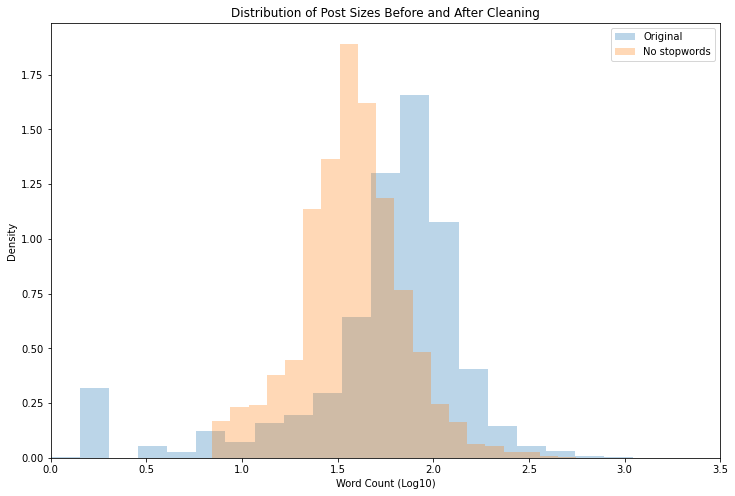

In [50]:
original_sizes = np.array(list(map(len, split_phrased_docs)))
clean_sizes    = np.array(list(map(len, clean_dataset)))

plt.figure(figsize=(12, 8))

count_plot_config = {
    "alpha": 0.3,
    "bins": 20,
    "density": True
}

# necessary to avoid taking the log of 0 if there are empty posts
# spoiler: there are empty posts
smoothing_factor = 1

plt.hist(np.log10(original_sizes + smoothing_factor), label="Original", **count_plot_config);
plt.hist(np.log10(clean_sizes    + smoothing_factor), label="No stopwords", **count_plot_config);

plt.xlim([0, 3.5])
plt.xlabel("Word Count (Log10)")
plt.ylabel("Density")
plt.title("Distribution of Post Sizes Before and After Cleaning")
plt.legend();

### TODO: There should be a note here explaining why this is useful

In [51]:
clean_dataset[0]

['hunt',
 'yellowtail',
 'today',
 'never',
 'able',
 'connect',
 'covered_a_lot_of_water',
 'handful',
 'fish',
 'giving',
 'yellowtail',
 'tomorrow',
 'new',
 'day',
 'wish_us_luck',
 'brian',
 'indy_crew']

In [52]:
import warnings
warnings.filterwarnings('ignore')

## Setting up the Topic Model - Asymmetric LDA


In [53]:
import gensim
import gensim.corpora as corpora

In [54]:
doc_lens = np.array(list(map(lambda x: len(x), clean_dataset)))

In [55]:
# Create Dictionary
id2word = corpora.Dictionary(clean_dataset)

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in clean_dataset]
print(len(corpus))

2656


In [56]:
n_topics = 10

In [57]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=n_topics, 
                                           random_state=12321,
                                           update_every=5,
                                           chunksize=550,
                                           passes=40,
                                           alpha='auto',
                                           per_word_topics=True)

## TODO: Explain this plot and give context. Is this learned or is it set? Provide interpretation

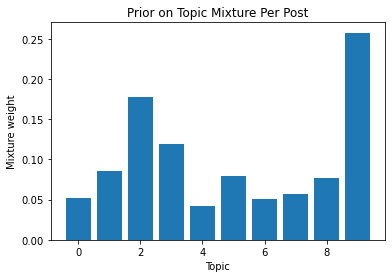

In [58]:
topic_prior = lda_model.alpha
topic_prior /= topic_prior.sum()

plt.bar(np.arange(n_topics), topic_prior)
plt.xlabel("Topic")
plt.ylabel("Mixture weight")

plt.title("Prior on Topic Mixture Per Post");

In [59]:
vocab = [word for key, word in id2word.items()]

In [60]:
topic_df = pd.DataFrame(lda_model.get_topics())
topic_df.columns = vocab
topic_df.head(2)

,able,brian,connect,covered_a_lot_of_water,day,fish,giving,handful,hunt,indy_crew,...,caps,generated,holders,liberty,masks,realize,rollos,worthwhile,applies,behold
0,0.000011,0.000410,0.000011,0.000011,0.004131,0.006284,0.000331,0.000011,0.000012,0.000584,...,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011,0.000011
1,0.000621,0.000323,0.000013,0.000013,0.008345,0.002561,0.000393,0.000013,0.000013,0.000261,...,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013,0.000013


In [ ]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

In [ ]:
# from pyLDAvis import save_html

# save_html(vis, "september_07_2021_LDA.html")

# TODO: Use topic matrix like word vectors. Use word similarity to find fish names?
# TODO: documents that have high theta values for interesting topics?
# TODO: find a way to extract fish species and measure mentions
# TODO: weather vs post content

```
conda install -c conda-forge spacy
conda install -c conda-forge spacy-lookups-data
python -m spacy download en_core_web_sm
python -m spacy download en_core_web_lg
```

# What can we learn from the data if we use look at word embeddings and entity types?

In [61]:
import spacy

nlp = spacy.load("en_core_web_lg")

def print_doc_with_context(texts):
    for doc in nlp.pipe(texts, disable=["tagger", "parser"]):
        # Do something with the doc here
        print([(ent.text, ent.label_) for ent in doc.ents])

In [62]:
doc_num = 2
print_doc_with_context(fishing_data.post_body[doc_num:doc_num + 1])

[('Another good day', 'DATE'), ('the morning', 'TIME'), ('Yellowfin Tuna', 'PERSON'), ('Yellowtail', 'PERSON'), ('Yellowtail', 'PERSON'), ('Brian Indy', 'PERSON')]


In [ ]:
def get_similar_words(word: str):
    OOV_words  = set()
    fish_names = set()
    for doc in nlp.pipe(fishing_data.post_body, disable=["parser"]):
        for tok in doc:
            if tok.is_oov:
                OOV_words.update({str(tok).lower()})
                continue
            # is this word semantically similar to yellowtail? keep it for further checks
            if tok.similarity(nlp.vocab["Yellowtail"]) >= 0.40:
                fish_names.update({str(tok).lower()})
                #print(tok.lemma_, tok.ent_type_, )
    return OOV_words, fish_names

In [77]:
nlp.vocab["Yellowtail"].vector

array([-5.6341e-01, -3.0155e-01,  3.3868e-01,  1.8589e-01,  3.5210e-01,
        3.0147e-01, -6.8685e-01, -2.8174e-01,  1.9149e-01, -6.6843e-01,
        2.6456e-01,  6.5088e-02, -4.3547e-01,  4.6700e-01, -8.1023e-01,
        4.5296e-01,  6.2391e-01, -5.6850e-01,  4.5296e-01,  1.3094e-01,
        1.8333e-02,  7.1113e-01, -1.5680e-01,  5.9686e-01, -8.7727e-01,
       -3.0838e-01,  2.6665e-01,  1.3956e-01, -2.7290e-01,  2.0211e-01,
        1.4173e-01, -8.0365e-02, -3.3162e-01, -1.3031e+00,  1.2146e-01,
       -1.6415e-01, -2.6853e-01, -7.2251e-02, -2.3021e-01,  8.1644e-01,
       -4.6641e-01,  7.0644e-01,  1.9382e-01, -7.8336e-03,  1.1854e+00,
        9.2996e-01,  5.0988e-01,  6.4293e-01,  2.9205e-01, -3.1813e-01,
        1.5310e-01,  6.3078e-01,  8.2406e-01,  6.5246e-02,  4.1730e-01,
        1.1934e-01,  1.2511e-01,  3.4589e-01,  2.5731e-01, -1.3842e-01,
        4.8021e-01, -8.5520e-01,  3.7370e-01,  2.2759e-01,  2.1531e-01,
       -5.2413e-01,  5.4761e-01,  3.9184e-01, -1.7159e-01,  4.71

In [63]:
OOV_words  = set()
fish_names = set()

In [64]:
for doc in nlp.pipe(fishing_data.post_body, disable=["parser"]):
    for tok in doc:
        if tok.is_oov:
            OOV_words.update({str(tok).lower()})
            continue
        # is this word semantically similar to yellowtail? keep it for further checks
        if tok.similarity(nlp.vocab["Yellowtail"]) >= 0.40:
            fish_names.update({str(tok).lower()})
            #print(tok.lemma_, tok.ent_type_, )
            
            
            

In [67]:
# OOV are words that dont exist in the embeddings (Out of Vocabulary)
OOV_words, fish_names = get_similar_words('Yellowtail')

In [68]:
fish_names

{'ahi',
 'albacore',
 'amberjack',
 'anchovy',
 'barracuda',
 'bluefin',
 'boated',
 'bonito',
 'crab',
 'croaker',
 'dorado',
 'dorados',
 'fish',
 'fishery',
 'flatties',
 'grouper',
 'groupers',
 'haddock',
 'halibut',
 'hamachi',
 'hammerheads',
 'inshore',
 'jigging',
 'kelp',
 'lingcod',
 'longfin',
 'mackerel',
 'mahi',
 'marlin',
 'pargo',
 'pelagic',
 'pollock',
 'rockfish',
 'salmon',
 'sardine',
 'sardines',
 'sashimi',
 'scad',
 'seabass',
 'seared',
 'shrimp',
 'skipjack',
 'snapper',
 'snappers',
 'sportfishing',
 'squid',
 'sushi',
 'swordfish',
 'tenderloin',
 'triggerfish',
 'tuna',
 'tunas',
 'wahoo',
 'wahoos',
 'yellowfin',
 'yellowtail'}

In [69]:
OOV_words

{'112410',
 '121910',
 '1904b',
 '1904c',
 '2sp',
 '2wahoo',
 '50ls',
 '50sds',
 '5777',
 '600n',
 '6364',
 '6455',
 '6460',
 '6463',
 '6465',
 '6470',
 '66463',
 '6xs',
 '700xh',
 '7455',
 '7460',
 '7465',
 '74656',
 '7567',
 '7691',
 '7xs',
 '91450',
 '94150',
 '94151',
 'abshear',
 'ackel',
 'actoin',
 'aftco',
 'aftern',
 'ahis',
 'aiso',
 'alajajyan',
 'albacore',
 'albies',
 'albro',
 'alexopoulos',
 'algaze',
 'alijos',
 'allos',
 'alpineri',
 'alpinieri',
 'alstrom',
 'alwine',
 'amistead',
 'amundson',
 'anderman',
 'andersonof',
 'andyone',
 'anglerettes',
 'antonini',
 'approxiamtely',
 'arellanos',
 'armenta',
 'asbel',
 'asbell',
 'auberry',
 'auburndale',
 'audette',
 'austrulid',
 'avet',
 'avets',
 'azmar',
 'b90s',
 'backie',
 'backuss',
 'baitrunner',
 'balbach',
 'ballyhood',
 'barriault',
 'barriult',
 'basmadjian',
 'bassing',
 'bassn',
 'bebuys',
 'beguns',
 'bellantonio',
 'bellflower',
 'benitos',
 'bentovoja',
 'besara',
 'beuttler',
 'bidinger',
 'bigguns',
 '

Out of vocabulary words (OOV) are those the model hasn't seen in training. Tracking these words from our own corpus is a great way to find jargon and misspellings. The more notable ones will be corrected by handle or added to a jargon mapping so we can explicitly convert the jargon to a more common phrase.

In [ ]:
OOV_words

In [78]:
jargon_fishnames = {
    "yft":  "yellowfin tuna",
    "reds": "red snapper/red cod",
    "bft":  "bluefin tuna",
    "ling": "lingcod",
    "yella":   "yellowtail tuna",
    "yellas":  "yellowtail tuna",
    "flyline": "live bait",
    "albies":  "albacore tuna",
    "bassing": "bass fishing",
    "schoolie": "small fish that swim in groups",
    "wsb":      "white sea bass" ,
    "rockfishing": "fishing for rockfish",
    "skippie": "skipjack", # bait fish
    "skippy":  "skipjack",
    "pargo":   "red snapper",
    "scad": "mackerel"
}


jargon_other = {
    "alijos":  "alijos rocks",
    "avet 2sp": "avet LX sp fishing reel",
    "bigguns": "big ones",
    "xxh": "xxh fishing reel",
    "kelps":   "kelp paddies",
    "Yellatailin":   "catching yellowtail",
    "yellowtailin":  "catching yellowtail",
    "yellowtailing": "catching yellowtail"
}

# combine jargon fish names with fish names found via word embeddings
fish_names |= set(jargon_fishnames.keys())

fish_names = fish_names - {'fish'}



In [79]:
fish_names


{'ahi',
 'albacore',
 'albies',
 'amberjack',
 'anchovy',
 'barracuda',
 'bassing',
 'bft',
 'bluefin',
 'boated',
 'bonito',
 'crab',
 'croaker',
 'dorado',
 'dorados',
 'fish',
 'fishery',
 'flatties',
 'flyline',
 'grouper',
 'groupers',
 'haddock',
 'halibut',
 'hamachi',
 'hammerheads',
 'inshore',
 'jigging',
 'kelp',
 'ling',
 'lingcod',
 'longfin',
 'mackerel',
 'mahi',
 'marlin',
 'pargo',
 'pelagic',
 'pollock',
 'reds',
 'rockfish',
 'rockfishing',
 'salmon',
 'sardine',
 'sardines',
 'sashimi',
 'scad',
 'schoolie',
 'seabass',
 'seared',
 'shrimp',
 'skipjack',
 'skippie',
 'skippy',
 'snapper',
 'snappers',
 'sportfishing',
 'squid',
 'sushi',
 'swordfish',
 'tenderloin',
 'triggerfish',
 'tuna',
 'tunas',
 'wahoo',
 'wahoos',
 'wsb',
 'yella',
 'yellas',
 'yellowfin',
 'yellowtail',
 'yft'}

In [80]:
pattern = re.compile(fr"(\d+)?\W+(\d+)?\W+(lb|pound)\W+({'|'.join(fish_names)})")
pattern

re.compile(r'(\d+)?\W+(\d+)?\W+(lb|pound)\W+(yft|inshore|yellowfin|groupers|swordfish|longfin|dorado|sardines|hammerheads|bluefin|pollock|skippy|bft|anchovy|sportfishing|fishery|crab|yellowtail|seabass|tunas|ling|croaker|snapper|amberjack|seared|dorados|fish|albies|rockfish|squid|pelagic|marlin|tenderloin|yellas|sashimi|tuna|boated|halibut|scad|skipjack|lingcod|ahi|sushi|haddock|bonito|wahoo|hamachi|bassing|mahi|pargo|wsb|kelp|mackerel|shrimp|salmon|flyline|flatties|reds|wahoos|snappers|skippie|albacore|yella|barracuda|schoolie|grouper|jigging|rockfishing|sardine|triggerfish)',
re.UNICODE)

In [81]:
def extract_fish_weights(phrase: str):
    return [[f"{x[0]}.{x[1]}", x[3]] for x in pattern.findall(phrase)]

In [82]:
fishing_data.post_body[:50].apply(extract_fish_weights)

0                             []
1                             []
2                             []
3                             []
4                             []
5              [[150.300, tuna]]
6                             []
7                             []
8                             []
9                             []
10           [[.49, yellowtail]]
11                            []
12                            []
13                            []
14                            []
15                            []
16                            []
17                            []
18                            []
19                            []
20                            []
21              [[90.200, fish]]
22                            []
23                            []
24               [[18.25, fish]]
25                            []
26                            []
27                            []
28                            []
29                            []
30        

In [83]:
# cases:
# 20 25 pound tuna: 20 - 25 pound fish
# (, 42, lb, bluefin): 42 lb fish
# (39, 6, lb, bluefin): 39.6 lb fish or 39 different 6lb fish?

In [84]:
fishing_data.post_body[5]

'These big Yellowfin Tuna are hard to catch but what an incredible sign off fish all day From sun rise to sunset their were 150 300 pound tuna boiling right next to the boat keeping us all excited Had a few heart breaks on big ones that got away but were able to land one at 203 pounds Try one more day for a fish of a life time Brian Indy crew'

In [85]:
print_phrase_with_context("yft", num_docs=5)

Example 1:
first place 72 lb yft christopher johnson 

Example 2:
1 jeff friesen 33 5 lb yft 2 matt fettig 32 5 lb yft 3 brandy anderson kevin abshear 30 0 lb yft 

Example 3:
we are welcomed back with 11 fish over 200 lb and 1 fish over 300 lbs what a great group of anglers and a great catch thanks again guys see y all again next year jackpot winners are 1 jim bowman 300 1 yft 2 sal proetto 273 yft 3 joe solomon 268 2 yft 

Example 4:
first willy scharfen 58 6 lb yft second chris johnson 49 8 lb yft third brett goldberg 46 8 lb wahoo congratulations to all looking forward to seeing you next year matt indy crew 

Example 5:
thank again roger for getting the gang back together see you guys soon first place bret mccoy 62 4 yft second place micheal hakala 58 3 yft third place joe russo 55 1 yft 



In [86]:
extract_fish_weights( "1 jeff friesen 33 5 lb yft 2 matt fettig 32 5 lb yft 3 brandy anderson kevin abshear 30 0 lb bft ")

[['33.5', 'yft'], ['32.5', 'yft'], ['30.0', 'bft']]

In [87]:
extract_fish_weights('first willy scharfen 58 6 lb yft second chris johnson 49 8 lb yft third brett goldberg 46 8 lb wahoo congratulations to all looking forward to seeing you next year matt indy crew ')

[['58.6', 'yft'], ['49.8', 'yft'], ['46.8', 'wahoo']]

In [88]:
d1, d2, weight, fish = ('', 42, 'lb', 'bluefin')

In [89]:
def bin_fish_sizes(tup):
    # looks like: ('39', '6', 'lb', 'bluefin')
    if len(tup) <= 2:
        return []
    d1, d2, weight, fish = tup
    
    if d1.strip() == '':
        out = {
            'case': 'nearest_pound',
            'value': d2,
        }
    elif (len(str(d2)) >= len(str(d1))) and (int(d2) > int(d1)):
        # case: 20 25 pound tuna: 20 - 25 pound fish
        out = {
            'case': 'range',
            'value': f"{d1}-{d2}",
        }

    else:
        # TODO: how can we tell if this is  10 5 lb fish or a single 10.5 lb fish?
        out = {
            'case': 'precise',
            'value': f"{d1}.{d2}",
        }
    out['species'] = fish
    out['metric'] = weight
    return out

In [93]:
fish_mentions = fishing_data.post_body.apply(lambda x: list(map(bin_fish_sizes, pattern.findall(x))))
fish_mentions


0                                                      []
1                                                      []
2                                                      []
3                                                      []
4                                                      []
                              ...                        
2892    [{'case': 'precise', 'value': '47.3', 'species...
2893                                                   []
2894    [{'case': 'range', 'value': '25-65', 'species'...
2895                                                   []
2896    [{'case': 'nearest_pound', 'value': '205', 'sp...
Name: post_body, Length: 2897, dtype: object

In [94]:
algo_hits = fish_mentions.loc[fish_mentions.apply(lambda x: x != [])]
algo_hits


5       [{'case': 'range', 'value': '150-300', 'specie...
10      [{'case': 'nearest_pound', 'value': '49', 'spe...
21      [{'case': 'range', 'value': '90-200', 'species...
24      [{'case': 'range', 'value': '18-25', 'species'...
43      [{'case': 'precise', 'value': '33.5', 'species...
                              ...                        
2890    [{'case': 'nearest_pound', 'value': '285', 'sp...
2891    [{'case': 'nearest_pound', 'value': '269', 'sp...
2892    [{'case': 'precise', 'value': '47.3', 'species...
2894    [{'case': 'range', 'value': '25-65', 'species'...
2896    [{'case': 'nearest_pound', 'value': '205', 'sp...
Name: post_body, Length: 528, dtype: object

In [92]:
samples = []

for i in range(30, 50):
    samples += [algo_hits.iloc[i]]
samples

[[{'case': 'nearest_pound', 'value': '25', 'species': 'fish', 'metric': 'lb'}],
 [{'case': 'nearest_pound',
   'value': '25',
   'species': 'yellowfin',
   'metric': 'lb'}],
 [{'case': 'nearest_pound', 'value': '30', 'species': 'fish', 'metric': 'lb'}],
 [{'case': 'nearest_pound',
   'value': '25',
   'species': 'yellowfin',
   'metric': 'lb'},
  {'case': 'nearest_pound', 'value': '25', 'species': 'tuna', 'metric': 'lb'}],
 [{'case': 'nearest_pound', 'value': '49', 'species': 'wahoo', 'metric': 'lb'},
  {'case': 'nearest_pound', 'value': '45', 'species': 'wahoo', 'metric': 'lb'},
  {'case': 'nearest_pound',
   'value': '40',
   'species': 'yellowfin',
   'metric': 'lb'}],
 [{'case': 'nearest_pound', 'value': '30', 'species': 'fish', 'metric': 'lb'}],
 [{'case': 'nearest_pound',
   'value': '30',
   'species': 'yellowtail',
   'metric': 'lb'},
  {'case': 'nearest_pound',
   'value': '29',
   'species': 'yellowtail',
   'metric': 'lb'},
  {'case': 'nearest_pound',
   'value': '44',
   's

# TODO: get counts of each fish mention. 
# Try to group jargon fish names with their actual name

In [103]:
fish_names

{'ahi',
 'albacore',
 'albies',
 'amberjack',
 'anchovy',
 'barracuda',
 'bassing',
 'bft',
 'bluefin',
 'boated',
 'bonito',
 'crab',
 'croaker',
 'dorado',
 'dorados',
 'fishery',
 'flatties',
 'flyline',
 'grouper',
 'groupers',
 'haddock',
 'halibut',
 'hamachi',
 'hammerheads',
 'inshore',
 'jigging',
 'kelp',
 'ling',
 'lingcod',
 'longfin',
 'mackerel',
 'mahi',
 'marlin',
 'pargo',
 'pelagic',
 'pollock',
 'reds',
 'rockfish',
 'rockfishing',
 'salmon',
 'sardine',
 'sardines',
 'sashimi',
 'scad',
 'schoolie',
 'seabass',
 'seared',
 'shrimp',
 'skipjack',
 'skippie',
 'skippy',
 'snapper',
 'snappers',
 'sportfishing',
 'squid',
 'sushi',
 'swordfish',
 'tenderloin',
 'triggerfish',
 'tuna',
 'tunas',
 'wahoo',
 'wahoos',
 'wsb',
 'yella',
 'yellas',
 'yellowfin',
 'yellowtail',
 'yft'}

In [95]:
for f in fish_names:
    fishing_data.loc[:, f] = fishing_data.post_body.str.count(f)

    

In [104]:
fishing_data.drop(labels=['fish'], axis=1, inplace=True)

In [106]:
top_fish_mentioned = fishing_data[list(fish_names)].sum(axis=0).sort_values(ascending=False)
top_fish_mentioned


tuna           1714
yellowtail      936
yellowfin       652
ling            397
bluefin         371
               ... 
dorados           0
pollock           0
sashimi           0
wsb               0
triggerfish       0
Length: 69, dtype: int64

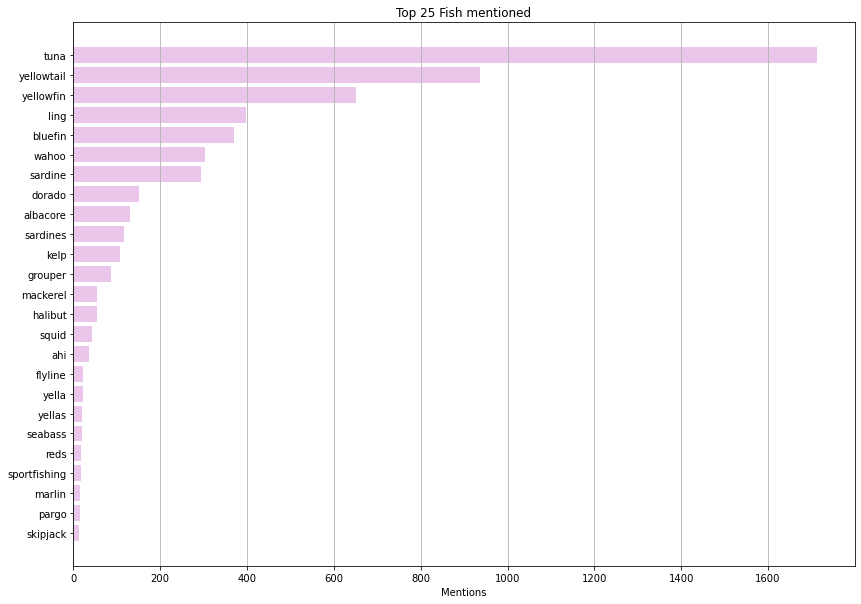

In [119]:
n = 25

fish_slice = top_fish_mentioned[:n]
names, counts = fish_slice.index, fish_slice.values

plt.figure(figsize=(14, 10))

plt.barh(names, counts, color='plum', alpha=0.6)
plt.gca().invert_yaxis() # prefer decreasing order of the bars

plt.title(f"Top {n} Fish mentioned")
plt.xlabel("Mentions")


plt.grid(axis='x');

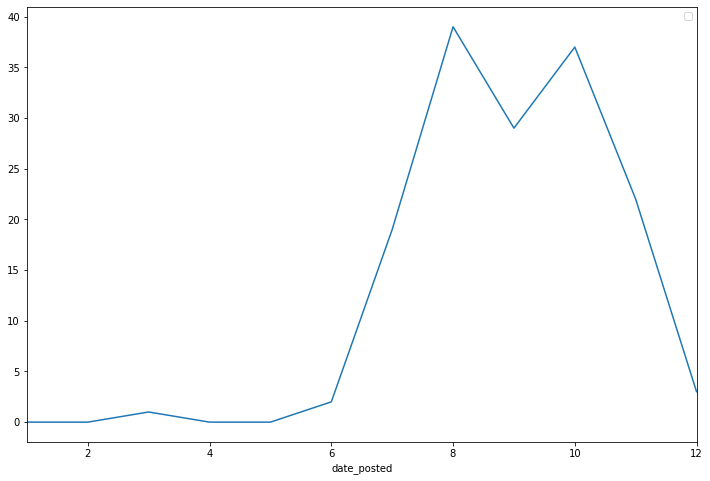

In [97]:
# fishing_data.groupby(fishing_data.date_posted.dt.month)[['bluefin', 'yellowtail', 'grouper']].sum().plot()
fishing_data.groupby(fishing_data.date_posted.dt.month)['dorado'].sum().plot(figsize=(12, 8))
# plt.xticks(labels=month_labels, rotation=45);
plt.legend([])



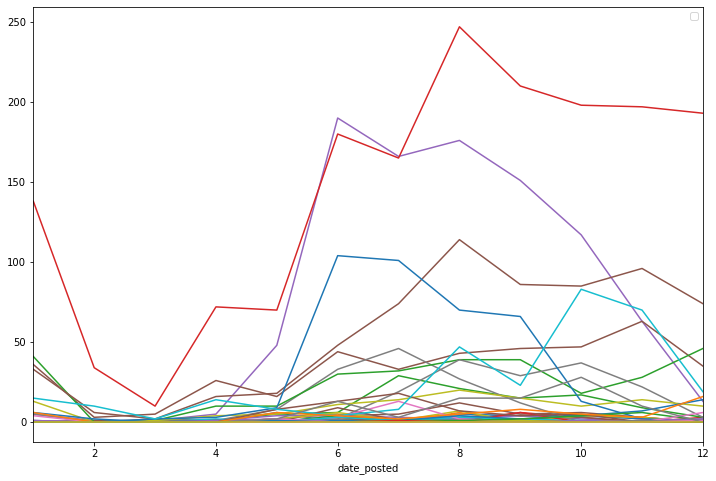

In [167]:
# fishing_data.groupby(fishing_data.date_posted.dt.month)[['bluefin', 'yellowtail', 'grouper']].sum().plot()
fishing_data.groupby(fishing_data.date_posted.dt.month)[list(fish_names)].sum().plot(figsize=(12, 8))
# plt.xticks(labels=month_labels, rotation=45);
plt.legend([])



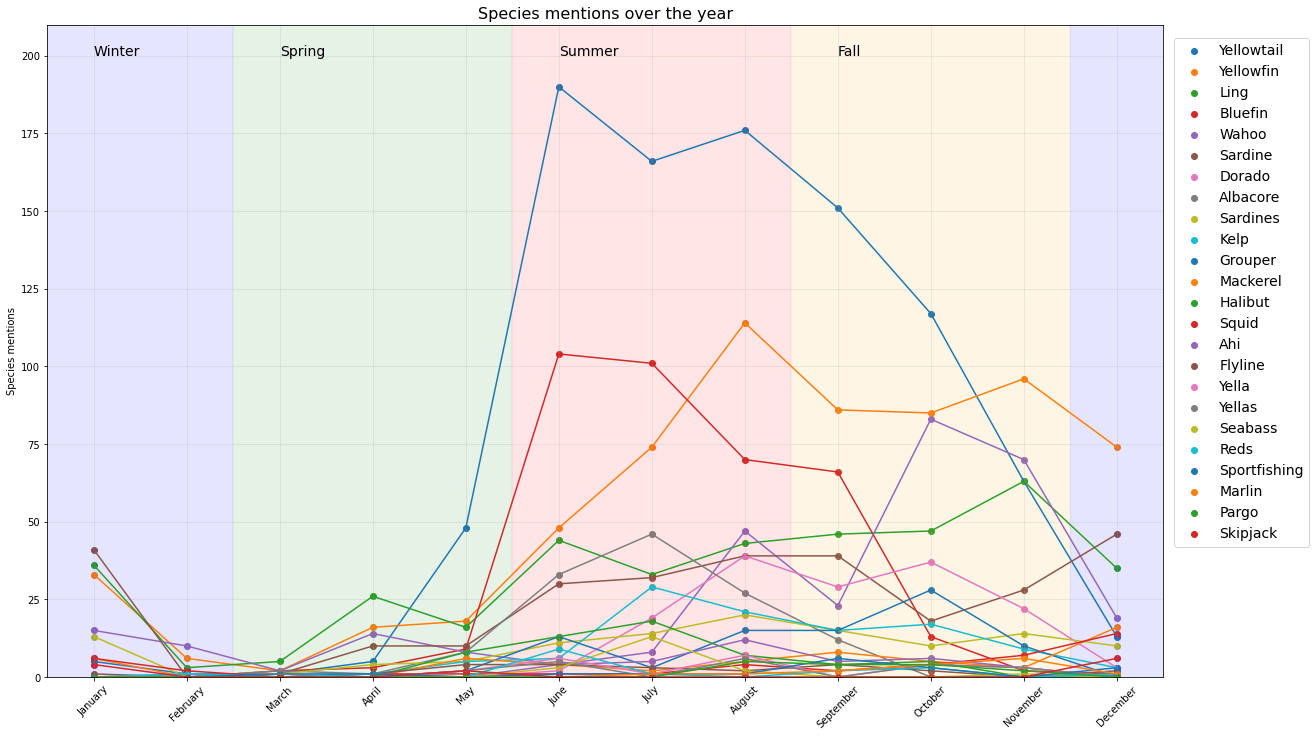

In [165]:
grouped_data = fishing_data.groupby(fishing_data.date_posted.dt.month)


plt.figure(figsize=(20, 12))
for f in names[1:]:
    monthly_total = grouped_data[f].sum()
    plt.scatter(monthly_total.index, monthly_total.values, label=f.title())
    plt.plot(monthly_total.index, monthly_total.values)
    
    
month_labels = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]

plt.xticks(monthly_total.index, labels=month_labels, rotation=45);

plt.legend(fontsize=14, loc=[1.01, .2]);

# Custom fill patterns to emphasize seasons
plt.fill_between([2.5, 5.49], 500,  alpha=0.1, color='green',  label='Spring')
plt.fill_between([5.5, 8.49], 500,  alpha=0.1, color='red',    label='Summer')
plt.fill_between([8.5, 11.49], 500, alpha=0.1, color='orange', label='Fall')
plt.fill_between([0, 2.49], 500,    alpha=0.1, color='blue',   label='Winter')
plt.fill_between([11.5, 12.5], 500, alpha=0.1, color='blue')


height = 200
plt.annotate("Winter", [1, height], fontsize=14)
plt.annotate("Spring", [3, height], fontsize=14)
plt.annotate("Summer", [6, height], fontsize=14)
plt.annotate("Fall",   [9, height], fontsize=14)

# plt.title("Seasonality of Fishing Reports (2005 - 2020)");
plt.ylim([0, height + 10])
plt.xlim([0.5, 12.5]);

#plt.savefig("post_seasonality.png", dpi=500);
    
    
    
plt.title("Species mentions over the year", fontsize=16)
plt.ylabel("Species mentions")
plt.grid(alpha=0.3)
#plt.legend(fontsize=14);

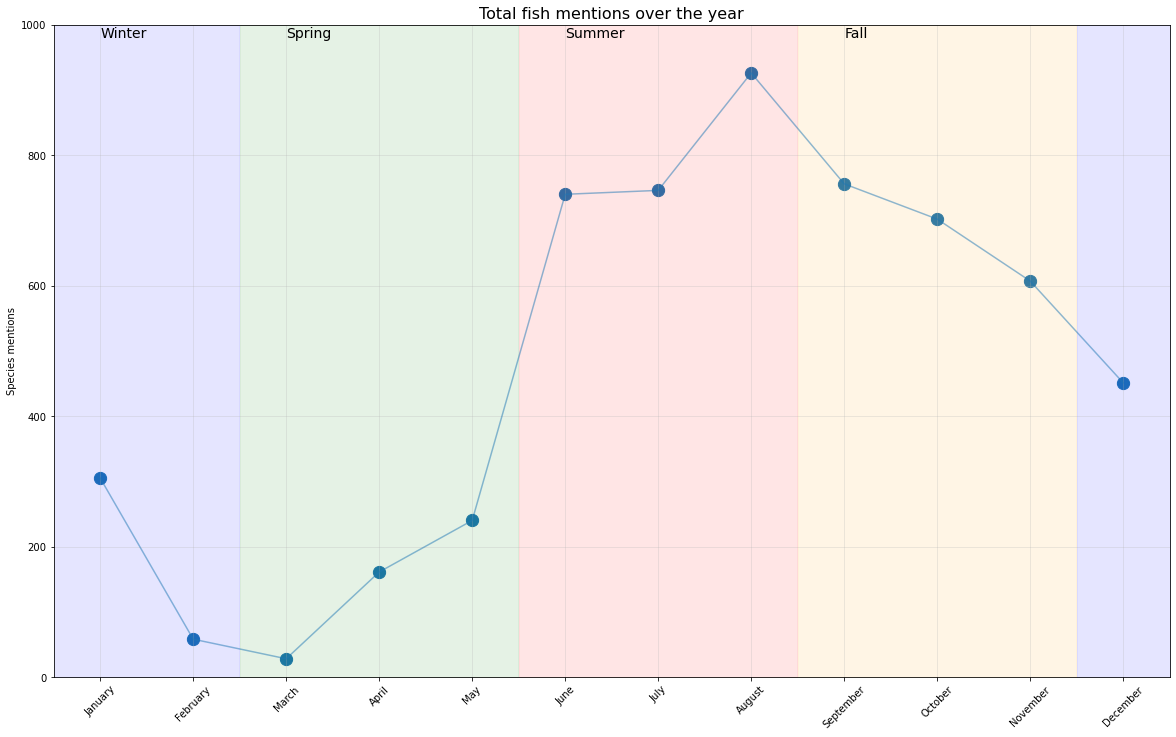

In [192]:
all_fish = fishing_data.loc[:, ['date_posted'] + list(fish_names)]
all_fish.loc[:, 'total_mentions'] = all_fish.loc[:, list(fish_names)].sum(axis=1)

grouped_data = all_fish.groupby(all_fish.date_posted.dt.month)


plt.figure(figsize=(20, 12))
monthly_total = grouped_data['total_mentions'].sum()
plt.scatter(monthly_total.index, monthly_total.values, label='All fish mentions', s=150)
plt.plot(monthly_total.index, monthly_total.values, alpha=0.5)
    
    
month_labels = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]

plt.xticks(monthly_total.index, labels=month_labels, rotation=45);

height = 1000

# Custom fill patterns to emphasize seasons
plt.fill_between([2.5, 5.49], height,  alpha=0.1, color='green',  label='Spring')
plt.fill_between([5.5, 8.49], height,  alpha=0.1, color='red',    label='Summer')
plt.fill_between([8.5, 11.49], height, alpha=0.1, color='orange', label='Fall')
plt.fill_between([0, 2.49], height,    alpha=0.1, color='blue',   label='Winter')
plt.fill_between([11.5, 12.5], height, alpha=0.1, color='blue')


plt.annotate("Winter", [1, height - 20], fontsize=14)
plt.annotate("Spring", [3, height - 20], fontsize=14)
plt.annotate("Summer", [6, height - 20], fontsize=14)
plt.annotate("Fall",   [9, height - 20], fontsize=14)

# plt.title("Seasonality of Fishing Reports (2005 - 2020)");
plt.ylim([0, height])
plt.xlim([0.5, 12.5]);

#plt.savefig("post_seasonality.png", dpi=500);
    
    
    
plt.title("Total fish mentions over the year", fontsize=16)
plt.ylabel("Species mentions")
plt.grid(alpha=0.3)
#plt.legend(fontsize=14);

In [190]:
fishing_data.groupby(fishing_data)

,date_posted,headline,post_body,low_temp,avg_temp,high_temp,inches_precip,miles_visible,max_wind,sea_pressure,...,skippie,albacore,yella,barracuda,schoolie,grouper,jigging,rockfishing,sardine,triggerfish
0,2020-12-17,ON THE HUNT,We were on the hunt for Yellowtail today but n...,46.0,57.34,64.0,0.00,10.0,10.0,30.08,...,0,0,0,0,0,0,0,0,0,0
1,2020-12-18,SCRATCHING AWAY,Searched for Yellowtail again today to find no...,52.0,58.04,66.0,0.00,10.0,9.0,30.23,...,0,0,0,1,0,0,0,0,0,0
2,2020-12-16,GOOD ACTION,Another good day of fishing for the guys It wa...,43.0,56.38,72.0,0.00,10.0,9.0,30.17,...,0,0,0,0,0,0,0,0,0,0
3,2020-12-15,GOOD DAY,The guys had an awesome day pulling on Yellowf...,49.0,57.24,68.0,0.03,10.0,9.0,30.21,...,0,0,0,0,0,0,0,0,0,0
4,2020-12-14,GOOD SIGN,Beautiful weather for the guys today Their are...,51.0,56.68,64.0,0.00,10.0,10.0,30.12,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2892,2006-01-03,Had Some Weather,Independence arrived at Pt Loma Sportfishing J...,50.0,55.57,61.0,0.00,10.0,20.0,30.23,...,0,0,0,0,0,0,0,0,1,0
2893,2020-12-19,ETA,The Independence will dock at Point Loma Sport...,43.0,56.67,70.0,0.00,10.0,14.0,30.28,...,0,0,0,0,0,0,0,0,0,0
2894,2020-08-25,GREAT TRIP,What a trip the guys had Started our trip out ...,73.0,75.59,80.0,0.00,10.0,14.0,29.84,...,0,0,0,0,0,0,0,0,0,0
2895,2017-12-20,AFTCO REPS COMMENTS,The trip started off at the bait receivers whe...,48.0,56.24,63.0,0.00,10.0,12.0,30.17,...,0,0,0,0,0,0,0,0,0,0


In [143]:
fishing_data.loc[fishing_data.date_posted.dt.month == 2, 'post_body'].values[7]

'We have not only enjoyed 7 beautiful days of fishing but all the travel days required to get there and back We will be docking at TIME__STAMP tomorrow sea ya then Jeff'

In [124]:
monthly_total


date_posted
1      6
2      2
3      0
4      1
5      1
6      1
7      1
8      4
9      2
10     4
11     7
12    14
Name: squid, dtype: int64

In [ ]:
import requests
from bs4 import BeautifulSoup

In [ ]:
webpage = requests.get("https://www.independencesportfishing.com/detailed_report.php?report_id=177553")

page_html = BeautifulSoup(webpage.text)
page_html

In [ ]:
print(page_html.find_all(class_='report_descript_data')[0].p.text)